# Evaluation of Bayesian Search for Debugging

## Motivation
Evolving code bases sometimes suffer from *regressions*. Regressions can be defined as something that once worked and now does not work anymore.

Searching for regressions in code bases can very well be done with Git Bisect [2]. As a prerequisite, one needs a test to determine if the fault is present or not. Also, the last version should be faulty and a previous version should be non-faulty.

Then, a binary search can be done over the history. This is extremely fast, because it requires only log(N) iterations. However, the prerequisite was that we can test for the faulty-ness.

However, not all faults are deterministic. Some faults are 'intermittent' or 'stochastic'. In this analysis, I will evaluate code on how to find the location of a fault given the stochastic behavior of a fault.

## BBChop
In 2009, "Ealdwulf Wuffinga" announced [1] on the git mailing list, that he had implemented a more general algorithm to finding bugs. He called it **BBChop**, for Bayesian Binary Chop. It is based on Bayesian Search Theory.

> BBChop is like git bisect (or equivalent), but works when your bug is intermittent. That is, it works in the presence of false negatives (when a version happens to work this time even though it contains the bug).
[3]

[1]: http://git.661346.n2.nabble.com/Generalised-bisection-td2447017.html 
[2]: https://git-scm.com/docs/git-bisect-lk2009.html
[3]: https://github.com/Ealdwulf/bbchop

## Analysis

I used *BBChop* and ran experimental runs with varying parameters and recorded how many *trials* where necessary to identify faults. 

### Note
When running a test provided with *BBChop*, I noticed that for large number of detections, `Beta(d+1, t+1) * P(L)` evaluates to 0, for `d, t` being large. This might be related to the poor perforamnce at `p < 0.1`.

Developers with practical experience in probability algorithms know, that it is often advisable for numerical stability to use the logarithm of probabilities rather than raw probabilities. The developer of BBChop knew this too, which is obvious from his use of logarithms inside the math functions, and of his use of Fraction module to avoid floats.

However, `Beta` is implemented as
``` 
def Beta(a, b):
   return exp(log(Gamma(a)) + log(Gamma(b) - log(Gamma(a+b))
```

It is not obvious, how to make use of logarithms all the way through the computations. 

There is the line `for li in likelihoods: probs.append(li/likelihoodTot)`, with `likelihoodTot` being the sum over some `Beta(., .) * P(.)`.

One possible solution would be to use the identity `log(a + b) = log(a) + log(1 + b/a)`. 
http://stats.stackexchange.com/a/66621 : Suggests to "Substract the maximum logarithm from all logs."


### Let's get started

In [2]:
%matplotlib inline

import json
import pandas as pd
import seaborn as sn

In [3]:
with open('results.json') as f: d = json.load(f)

In [4]:
df = pd.DataFrame.from_dict(d)
df.head()

,N,certainty,fail_loc,fail_prob,seed,success,trials,where
0,1000,0.7,700,0.010,1,False,629,904
1,1000,0.7,500,1.000,2,True,13,500
2,10,0.7,7,0.005,4,True,1238,7
3,100,0.9,50,0.010,1,True,1276,50
4,100,0.9,50,0.250,1,True,47,50


You can see that there are the following columns:

* `N`: Size of the range to search. For example, the number of commits in a code base. I used 10, 100, and 1000.
* `certainty`: How certain to be before terminating the search. I used two values here. 0.9 and 0.7 (90% and 70%, respectively).
* `fail_loc`: The location where the first failure occured. I used `0.7 * N`, and `0.5 * N`.
* `fail_prob`: The rate of failure, if the fault is present. So after `fail_loc` it will fail with probability  `fail_prob`, before `fail_loc` it will never fail.
* `seed`: The pseudo-random number generator's seed. I used this, so that results would be reproducible.
* `success`: If the found location (`where`) equals the `fail_loc`.
* `trials`: How many trials were needed to come to a solution.
* `where`: Where the fault was thought to be. If that location is the true faulty location, then `success == True`.

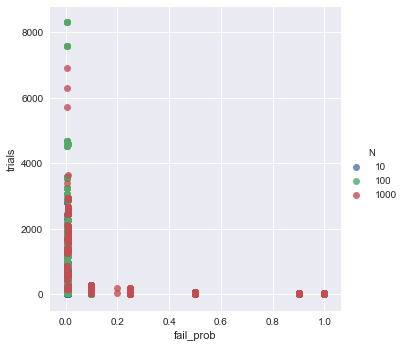

In [5]:
sn.lmplot(x='fail_prob', y='trials', data=df, hue='N', fit_reg=False) 

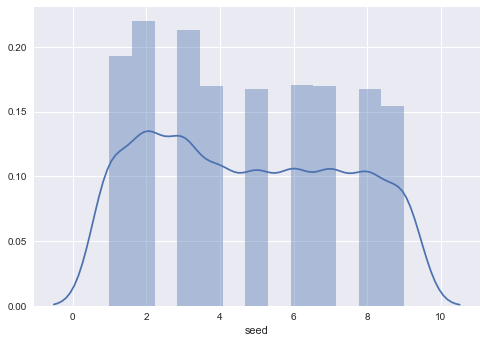

In [6]:
sn.distplot(df['seed'])

Not very helpful, the distribution of seeds. Basically between 1 and 9.

Trials vs Probability is not very informative. Not even, when I separate by 'N', the size of my history.

But I am suspecting that there is a bug for small probabilities. Let's filter those out.

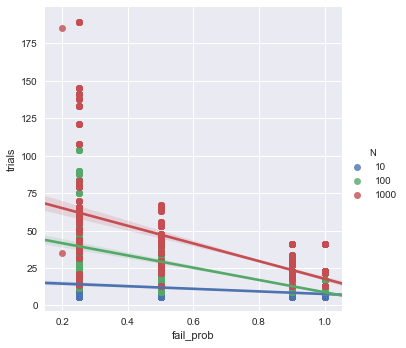

In [7]:
df_large_prob = df[df.fail_prob > 0.1]
sn.lmplot(x='fail_prob', y='trials', data=df_large_prob, hue='N')

That is more like it. 

1. The higher 'N', the more trials are needed. This is what I would expect.
2. The lower the failure probability, the more trials are needed. Again, that sounds very reasonable.

Next, let's do a violin plot to see the distribution at each probability.

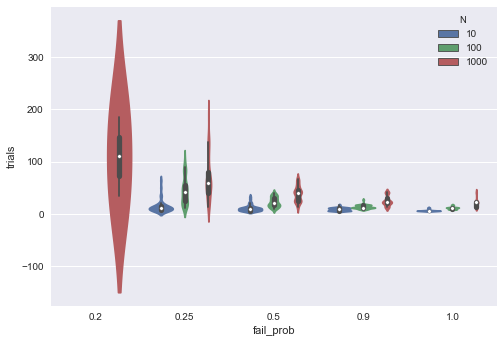

In [8]:
sn.violinplot(x='fail_prob', y='trials', hue='N',
                     data=df_large_prob)

Can you see anything? I can't. 

But, I think, I'd like to see the same for only `N = 1000` and `split` the Violin Plot on `success`. Because, honestly, I don't care much about `success == False` cases.

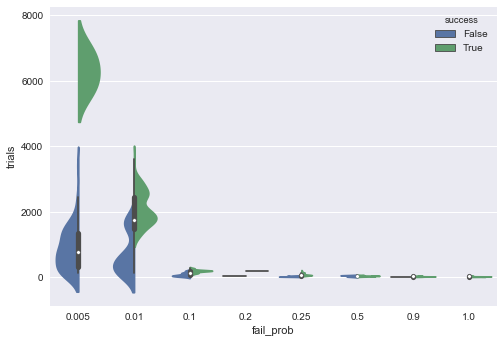

In [9]:
df_N1000 = df.query('N == 1000')
sn.violinplot(x='fail_prob', y='trials', hue='success', data=df_N1000, split=True)

Very nice! First observation: Probabilities below 0.1 are different. Just, to be save, let's do a log-plot.
Second observation: At low probabilities success or failure makes all the difference to the number of trials.

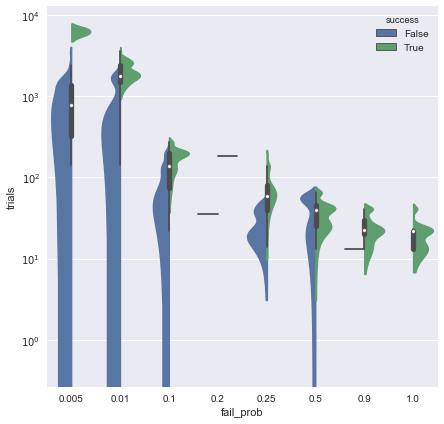

In [10]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
sn.violinplot(x='fail_prob', y='trials', hue='success', data=df_N1000, split=True, ax=ax)

That looks certainly better, but for now, I want to limit my observation to p in [0.1, 1.0]. And stay with a linear axis.

Next, loet's repeat the step from above and show trials vs probabilites for N = 1000, and p >= 0.1

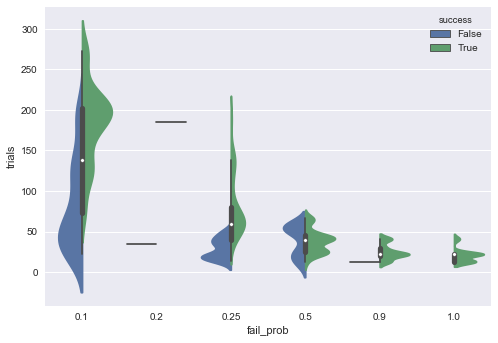

In [11]:
df_N1000_large_p = df.query('N == 1000').query('fail_prob >= 0.1')
sn.violinplot(x='fail_prob', y='trials', hue='success', data=df_N1000_large_p, split=True)

My colleague saw this the other day, and asked whether the distributions are bimodal. So, how many data points are there for each violin-plot?

In [12]:
df.query('N == 1000').groupby('fail_prob').size()

fail_prob
0.005     63
0.010    147
0.100    188
0.200      2
0.250    192
0.500    192
0.900    192
1.000    127
dtype: int64

192 values for 0.250. That seems enough.

Next, I want to produce another plot. Trials vs Commits to search, parameterised over p.

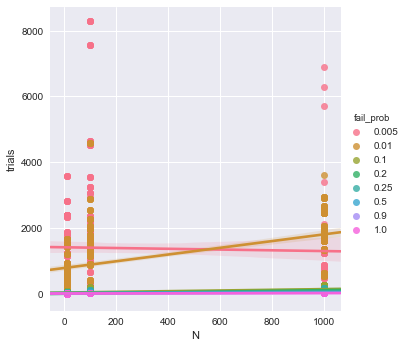

In [13]:
sn.lmplot(x='N', y='trials', data=df, hue='fail_prob')

Not useful at all.

1. I need some values for N between 100 and 1000.
2. There are too many 'hues' or 'fail_prob'. --> In the next plot, I will only pick [0.1, 0.5, 1.0].
3. That linear interpolation is obviously not what I want.
  * Let's turn it off.
  * Or, let's replace it with a `log(N)` regression. Why `log(N)`, because that is what I get with binary search.
  
Let's thin the plot down a bit:

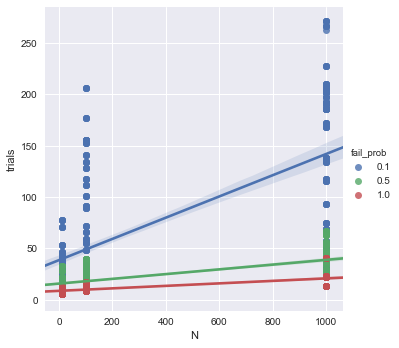

In [14]:
sn.lmplot(x='N', y='trials', data=df.query('fail_prob in [0.1, 0.5, 1.0]'), hue='fail_prob')

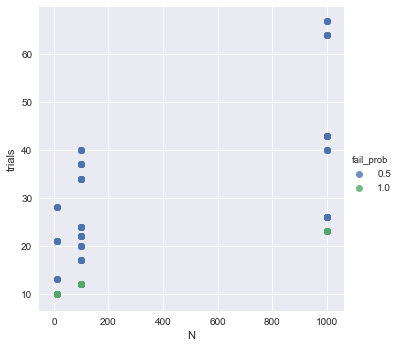

In [35]:
# Better, but let us try with only 'success'
sn.lmplot(x='N', y='trials', data=df.query('fail_prob in [ 0.5, 1.0] and fail_loc in [5, 50, 500] and certainty == 0.9').query('success == True'),
          hue='fail_prob', fit_reg=False)

### Plot 3:  BBChop vs Git Bisect

How does BBChop fare against Git Bisect, if the fault is not intermittent. For that let's compare the graph of p = 1.0 and Git Bisect's `ceil(log(N, base=2))`.

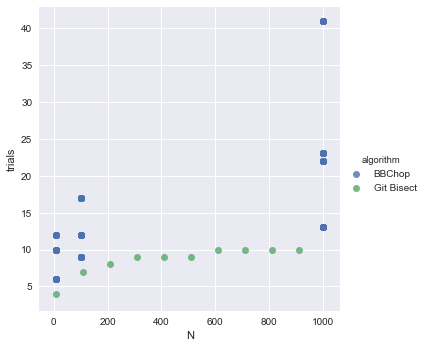

In [30]:
# df2: A view of [N, trials]
df2 = df.query('fail_prob == 1.0 and success == True')[['N', 'trials']]
df2.insert(len(df2.columns), 'algorithm', 'BBChop')

# Git Bisect performance.
x = list(range(10, 1000, 100))
from math import ceil, log2
y = list(map(lambda n: ceil(log2(n)), x))
df3 = pd.DataFrame.from_items([('N', x), ('trials', y), ('algorithm', 'Git Bisect')])

sn.lmplot(x='N', y='trials', data=pd.concat([df2, df3]), hue='algorithm', fit_reg=False)

## Todo
1. With p = 1.0, evaluate N = range(10, 1000, 10). Update Plot 3.
2. With p = [0.1, 0.5, 1.0], evaluate N = range(10, 1000, 10). Update Plot 2.